# 1. The frequency factor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

## 1.1 Determining the value of K

From McKeever's equation for the frequency factor:
$$ S = \nu_{ph} ~ K ~ e^{\frac{\Delta S}{k_B}} $$

For the known values from `ParametrosCineticos.xlsx` of $s$, and taking the value of $\nu_{ph}$ of the LiF, solving for $K$ yields:

$$ K = \frac{s}{\nu_{ph} ~ e^{\left(\Delta S /k_B \right) }}$$

In [ ]:
# Constants
kB = 8.617e-5                # (eV/K)
nu_m = 90000                 # from the Bransden book (m-1)
nu_s = 2.9979e8 * nu_m       # (s-1)
delta_S = 1.5 * kB           # (eV/K)

PathCinetics = 'Simulations/ParametrosCineticos.xlsx'
CineticsData = pd.read_excel(PathCinetics, sheet_name='Hoja1', header=0, usecols=None, nrows=None)

S = [CineticsData.iloc[i, 1] for i in range(6)]                            # Frequency factor for trap i (s-1)
S_R_h, S_NR_h = CineticsData.iloc[0, 3], CineticsData.iloc[0, 5]           # Frequency factor for radiative/ non radiative recombination centers (s-1)
S_all = S + [S_R_h, S_NR_h]  # Flatten S_all into a single list of scalar values

# Mean frequency factor
S_mean = np.mean(S_all)
K_mean = S_mean / (nu_s * np.exp(delta_S / kB))

# Value of K
K = np.zeros(len(S_all))
names = ['I', 'II', 'III', 'IV', 'V', 's', 'R', 'NR']
for i in range(len(S_all)):
    K[i] = S_all[i] / (nu_s * np.exp(delta_S / kB))
    print(f"Value of K for trap {names[i]}: {K[i]:.2e} s-1")

print(f"Value of K: {K_mean:.2e} s-1")


# Plots

## 2.1 Effect of irradiation

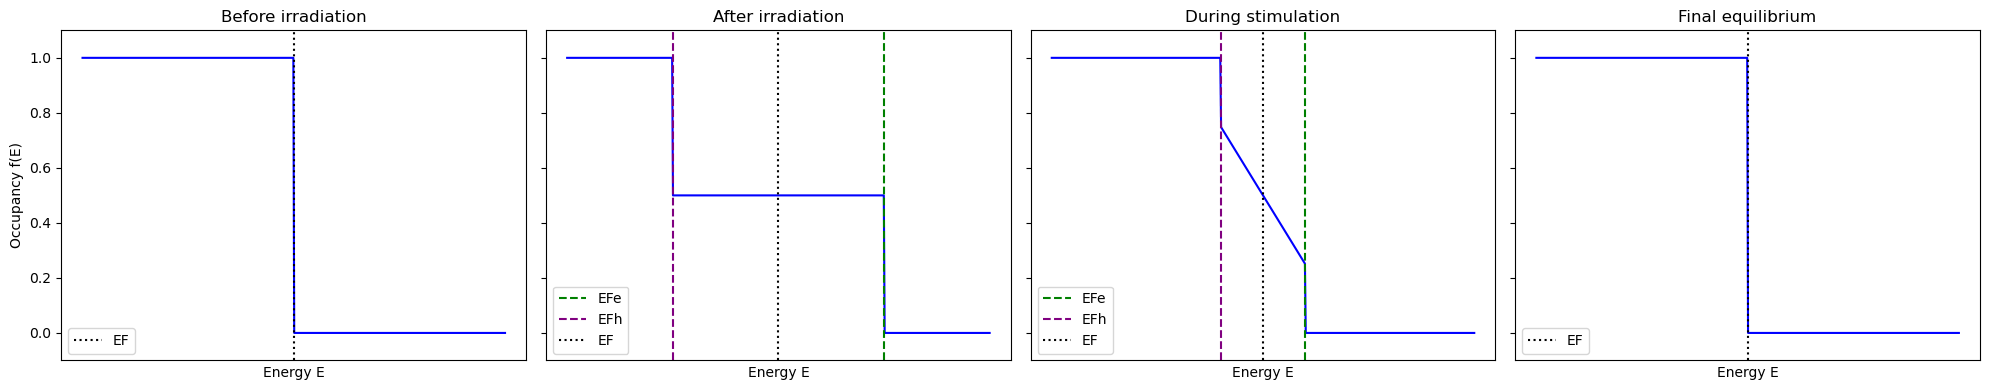

In [42]:
## FOR THE CASE OF THE STEP FUNCTION T = 0 K
# Energy range
E = np.linspace(-1, 1, 500)

# Fermi-Dirac distribution at 0 K
def fermi_0K(E, Ef):
    return np.where(E < Ef, 1, 0)

# State inmediately before irradiation: definition of the quasi-Fermi level
def irradiated_occupancy_0K(E, Ef, Efe, Efh):
    f = np.zeros_like(E)
    f[E < Efh] = 1
    f[(Efh <= E) & (E <= Efe)] = 0.5  # partial occupation (idealized)
    return f

# State during irradiation: smooth transition between EFe and EFh
def stimulated_occupancy_0K(E, Ef, Efe, Efh):
    f = np.zeros_like(E)
    mask = (Efh <= E) & (E <= Efe)
    f[E < Efh] = 1
    f[mask] = 0.75 - 0.5 * (E[mask] - Efh) / (Efe - Efh)  # lineal transition
    return f

# Level definitions
Ef = 0.0                 # original Fermi level
Efe_initial = 0.5
Efh_initial = -0.5
Efe_mid = 0.2
Efh_mid = -0.2

# Functions for plotting
f_before = fermi_0K(E, Ef)
f_after = irradiated_occupancy_0K(E, Ef, Efe_initial, Efh_initial)
f_during = stimulated_occupancy_0K(E, Ef, Efe_mid, Efh_mid)
f_final = fermi_0K(E, Ef)

# Plot
fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
titles = ['Before irradiation', 'After irradiation', 'During stimulation', 'Final equilibrium']
occupancies = [f_before, f_after, f_during, f_final]
labels = ['EF', (Efe_initial, Efh_initial), (Efe_mid, Efh_mid), 'EF']

for i in range(4):
    axs[i].plot(E, occupancies[i], color='blue' if i == 1 else 'blue')
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Energy E')
    axs[i].set_ylim(-0.1, 1.1)
    axs[i].set_xticks([])

    # Vertical lines for Fermi levels
    if i == 1 or i == 2:
        Efe, Efh = labels[i]
        axs[i].axvline(Efe, color='green', linestyle='--', label='EFe')
        axs[i].axvline(Efh, color='purple', linestyle='--', label='EFh')
        axs[i].axvline(Ef, color='black', linestyle=':', label='EF')
        axs[i].legend(loc='lower left')
    else:
        axs[i].axvline(Ef, color='black', linestyle=':', label='EF')
        axs[i].legend(loc='lower left')

    if i == 0:
        axs[i].set_ylabel('Occupancy f(E)')

axs[0].legend(loc='lower left')
plt.tight_layout()
plt.show()


/var/folders/_c/s9xtx7kn61l5wvpw4pyjsc8c0000gn/T/ipykernel_43514/1554789493.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((E - Ef) / (kB * T)))


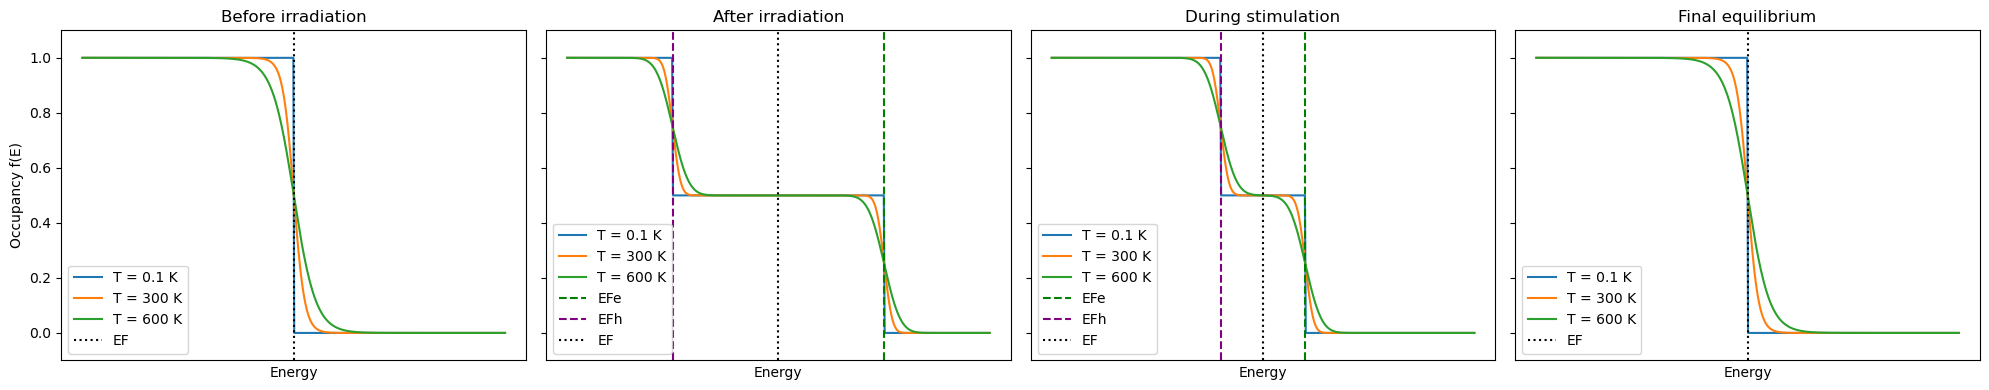

In [ ]:
## FOR THE CASE OF A NON ZERO TEMPERATURE

# Energy and temperature range
E = np.linspace(-1, 1, 500)
Ts = [0.1, 300, 600]  # K

# Fermi-Dirac distribution at T > 0 K
def fermi_T(E, Ef, T):
    kB = 8.617e-5  # eV/K
    return 1 / (1 + np.exp((E - Ef) / (kB * T)))

# State during irradiation: smooth transition between EFe and EFh
def irradiated_occupancy_T_temp(E, Efe, Efh, T):
    """
    Constructs a piecewise occupancy function with smoothing based on temperature.
    Sharp at low T, smooth at high T. Matches visual expectation.
    """
    f = np.zeros_like(E)
    f[E < Efh] = 1
    f[(E >= Efh) & (E <= Efe)] = 0.5
    f[E > Efe] = 0

    # Smooth with Gaussian kernel whose width depends on T
    sigma = T / 40  # Empirical smoothing factor
    return gaussian_filter1d(f, sigma=sigma)

# Level definitions
Ef = 0.0                 # original Fermi level
Efe_initial = 0.5
Efh_initial = -0.5
Efe_mid = 0.2
Efh_mid = -0.2

# Temperatures
T = 300  # K
f_before = np.zeros((len(Ts), len(E)))
f_after = np.zeros((len(Ts), len(E)))
f_during = np.zeros((len(Ts), len(E)))
f_final = np.zeros((len(Ts), len(E)))

# Functions for plotting
for t in range(len(Ts)):
    f_before[t] = fermi_T(E, Ef, Ts[t])
    f_after[t] = irradiated_occupancy_T_temp(E, Efe_initial, Efh_initial, Ts[t])
    f_during[t] = irradiated_occupancy_T_temp(E, Efe_mid, Efh_mid, Ts[t])
    f_final[t] = fermi_T(E, Ef, Ts[t])

    # Plot the curves for each temperature in the for loop

# Plot
fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
titles = ['Before irradiation', 'After irradiation', 'During stimulation', 'Final equilibrium']
occupancies = [f_before, f_after, f_during, f_final]
labels = ['EF', (Efe_initial, Efh_initial), (Efe_mid, Efh_mid), 'EF']

for i in range(4):
    for t in range(len(Ts)):
        axs[i].plot(E, occupancies[i][t], label=f'T = {Ts[t]} K')
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Energy')
    axs[i].set_ylim(-0.1, 1.1)
    axs[i].set_xticks([])

    # Vertical lines for Fermi levels
    if i == 1 or i == 2:
        Efe, Efh = labels[i]
        axs[i].axvline(Efe, color='green', linestyle='--', label='EFe')
        axs[i].axvline(Efh, color='purple', linestyle='--', label='EFh')
        axs[i].axvline(Ef, color='black', linestyle=':', label='EF')
    else:
        axs[i].axvline(Ef, color='black', linestyle=':', label='EF')

    if i == 0:
        axs[i].set_ylabel('Occupancy f(E)')
    axs[i].legend(loc='lower left')
plt.tight_layout()

# Save image to 'Images' folder
fig.savefig('LaTeX/Images/FD_irradiation.png', dpi=300, bbox_inches='tight')
plt.show()